# "Efficient Dynamic Batching of Large Datasets with Infinibatch"
> "We will explore how to efficiently batch large datasets with varied sequence length for training using [infinibatch](https://github.com/microsoft/infinibatch/)."

- toc:true
- badges: true
- comments: true
- categories: [deep learning]

We will explore how to efficiently batch large datasets with varied sequence length for training using [infinibatch](https://github.com/microsoft/infinibatch/). 

 We will focus on solving multiple challenges associated with this together and make it work with dataloaders in pytorch library.Infinibatch is a pure python library which is agnostic of the deep learning library used.

> Note: We will use [wikitext-103](https://blog.einstein.ai/the-wikitext-long-term-dependency-language-modeling-dataset/) dataset as an example. It's a dataset with sentences from wikipedia. It has 103,227,021 word level tokens in it's training split. It is just for illustration, the techniques we discuss are for scaling for far larger dataset sizes.



In [1]:
#collapse-hide
!wget https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
!unzip wikitext-103-raw-v1.zip

--2020-09-13 16:56:29--  https://s3.amazonaws.com/research.metamind.io/wikitext/wikitext-103-raw-v1.zip
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.217.43.102
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.217.43.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 191984949 (183M) [application/zip]
Saving to: ‘wikitext-103-raw-v1.zip’

wikitext-103-raw-v1 100%[===================>] 183.09M  16.5MB/s    in 12s     

2020-09-13 16:56:43 (14.9 MB/s) - ‘wikitext-103-raw-v1.zip’ saved [191984949/191984949]

Archive:  wikitext-103-raw-v1.zip
   creating: wikitext-103-raw/
  inflating: wikitext-103-raw/wiki.test.raw  
  inflating: wikitext-103-raw/wiki.valid.raw  
  inflating: wikitext-103-raw/wiki.train.raw  


# Challenges in efficiently processing large datasets



## 1. Loading and shuffling large datasets

For large datasets, loading the entire data into memory might not be possible. If we are to sample fully random batches, we would need to do random access on huge dataset. Depending on the disk latency this might be unfeasible. 

To solve this, we need to

1. Shard the data into chunks larger than single instances so that it reduces the disk access.
2. We can then shuffle the chunks and load few of them and shuffle the data loaded from the chunks.

If we shard the pieces into too big chunks we might end up loosing statistical power in our training updates as we are essentially reducing the randomness of our samples used for training. But we can't shard them too small either as that wouldn't solve our disk access problem.

So a flexible approach would make it easy to control how much data is to be loaded into memory for shuffling. To address this challenge in isolation, you can refer dataset sharding logic in NVIDIA's [MEGATRON language model training code](https://github.com/NVIDIA/Megatron-LM/blob/main/megatron/data/indexed_dataset.py) as an example.





## 2. Dynamic Batching

NLP datasets generally have samples which are of varied lengths. When we batch the data for training on devices like GPU generally we are forced to make them into n-dimensional tensors with fixed dimension. The most common type of input for NLP models is of the shape **Batch size x Sequence length**, where the sequence length is either a fixed value or is the length of longest sequence in that batch. The shorter sequences are generally padded with a *padding token*. 

These padding tokens are wasteful in terms of computation as they are not used to do anything useful other than to overcome the hardware architecture which allows only fixed size tensor computation to be done fast.

Some tutorials and examples you would find for pre-processing data would pad batches to a pre-determined sequence length independent of the elements in each batch. This is completely wasteful as many batches would have all the members less than the pre-deterimend length.

A better option is to pad the elements of each batch to the sequence length which is maximum in that batch. This **dynamic padding** can improve efficiency but it doesn't solve the entire problem. Let's see why with an example.


### Tokenization and length distribution

Let's implement a typical dynamic batching workflow with pytorch dataloader and a subword level tokenizer. We use BERT-base-cased tokenizer from huggingface's transformers library. This  tokenizes words to subwords. The BERT model was pre-trained with maximum subword length of 512. We can theoretically use sequence lengths larger than that but for our purposes  we will leave it as such at 512.


We will use torch's [dataset and dataloader](https://pytorch.org/docs/stable/data.html) abstraction for this. It will as both an illustration of real world usage and is convinent as it helps avoid having to entire tokenized dataset in memory We still have to load the sentences into memory once. This is not a problem for small datasets, but for very large corpuses it's a big problem. We will see soon that infinibatch solves also this problem elegantly.


In [ ]:
#collapse-hide
!pip install git+https://github.com/microsoft/infinibatch.git transformers torch
from typing import Dict, List
import torch
from torch.utils.data import Dataset, DataLoader
import tqdm
from transformers import AutoTokenizer, PreTrainedTokenizerFast

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch

%matplotlib inline

In [3]:
class Wiki103(Dataset):
    def __init__(self, tokenizer: PreTrainedTokenizerFast, data_path="wikitext-103-raw/wiki.train.raw", max_length: int = 512):
        self.tokenizer = tokenizer
        with open(data_path) as dp:
            # We are 
            self.sentences = [sentence.strip() for sentence in dp if len(sentence.strip()) > 2]
        self.max_length = max_length

    def __len__(self):
        return len(self.sentences)
    
    def __getitem__(self, i) -> Dict[str, torch.Tensor]:
        return self.tokenizer(self.sentences[i], max_length=self.max_length, truncation=True)


In [4]:
tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
wiki_dataset = Wiki103(tokenizer=tokenizer)
sequence_lengths = []
for example in tqdm.tqdm(iter(wiki_dataset)):
    sequence_lengths.append(len(example["input_ids"]))

1164464it [04:14, 4568.74it/s]


Plotting the truncated subword token length distribution we see that the distribution is wide with a large variance.

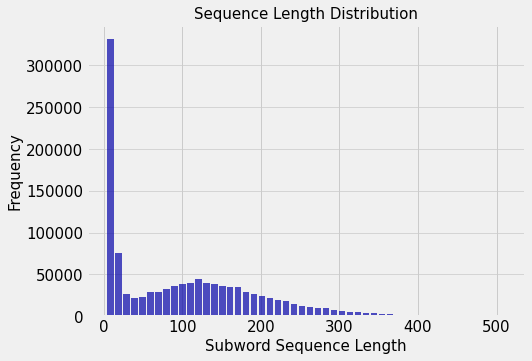

In [5]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=[7,5])
    n, bins, patches = plt.hist(x=sequence_lengths, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Subword Sequence Length',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Sequence Length Distribution',fontsize=15)
    plt.show()

### Dynamic Padding

From the above graph we can intuit that if we draw random samples from the data to form a batch, we would have few examples which are significantly longer than the rest. This would mean we would have to add lot of padding tokens. This holds even if we clean the very short length instances as noise. Let's implement dynamic padding and measure how much. 

We can use torch's `DataLoader` abstraction to do efficient batching with multi-processing. Since our tokenized outputs are of different lengths we have to implement a `collate` function to pad them dynamically together. We can pass the `tokenizer.pad` function to do this.

In [6]:
def collate_fn(examples: List[Dict[str, torch.Tensor]]) -> Dict[str, torch.Tensor]:
    # Since huggingface has already implemented this, this function is just to illustrate what a collator does.
    return tokenizer.pad(examples, return_tensors='pt')

dataloader = DataLoader(dataset=wiki_dataset, batch_size=32, collate_fn=collate_fn)

Assume we can accomodate at maximum a batch size of 32 for max sequence length of 512 in our training hardware. The tokens per batch would be `512 * 32 = 16384`. Let's compute how much of it is padding tokens and what is the distribution of the batch's sequence length(which depends on the maximum element in the batch).

In [7]:
total_tokens = 0
padding_tokens = 0
batch_lengths = []
for batch in tqdm.tqdm(iter(dataloader)):
    batched_input_ids = batch["input_ids"]
    batch_lengths.append(batched_input_ids.shape[1])
    total_tokens += batched_input_ids.numel()
    padding_tokens += batched_input_ids[batched_input_ids == tokenizer.pad_token_id].numel()

100%|██████████| 36390/36390 [05:42<00:00, 106.17it/s]


In [8]:
print(f"Total Batches    : {len(iter(dataloader))}")
print(f"Padding Tokens   : {padding_tokens}")
print(f"Input Tokens     : {total_tokens - padding_tokens}")
print(f"Total Tokens     : {total_tokens}")
print(f"Padding Tokens % : {(padding_tokens*100)/total_tokens}")

Total Batches    : 36390
Padding Tokens   : 244072396
Input Tokens     : 119699332
Total Tokens     : 363771728
Padding Tokens % : 67.09493267712108


Look at that, **67% of our net tokens are padding tokens**. This would imply that of all the computations we do only 33% of it is done usefully. So this starkly highlights the problem with static batch lengths even when accounting for dynamic padding. 

Let's also plot the distribution of batch lengths.

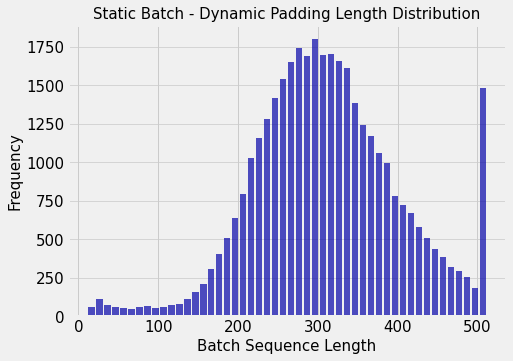

In [9]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=[7,5])
    n, bins, patches = plt.hist(x=batch_lengths, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Batch Sequence Length',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Static Batch - Dynamic Padding Length Distribution',fontsize=15)
    plt.show()

As batches are randomly sampled, we see a normal distribution as we can by the Central Limit Theorem. The frequency in the final bin is deviant because we have a significant number of sentences which we had truncated, hence batches with them will have the maximum sequence length.

### General approach to dynamic batching and it's challenges.


Now that we have seen the problem with static batching, let's see how to solve that. 

Instead of drawing samples in random, had we sorted our dataset by length, then we can form batches by packing similar length sequences together until we reach the maximum number of tokens that we can fit. This would typically be our previous memory limit of *static_batch x max_sequence_length*. This allows us to pack more instances in one batch without much padding.

But we can't do that because machine learning training is based on the assumption that our instances are drawn independently from an identical distribution. If we were to sort the entire dataset this breaks the assumption completely as our samples are no longer drawn independently from each other. If sentence length were a confunding factor then the model might fit on this spurious correlation.

So we have a trade-off here between statistical power derived from randomization of our samples and lesser error in gradient updates derived from larger batch sizes if we batch dynamically.

Generally, we can have a positive trade off by sampling a window of instances and sorting withing the window and forming batches.


The `Dataset` we implemented above is a [map-style](https://pytorch.org/docs/stable/data.html#map-style-datasets) dataset. It implements length and random access to each individual data sample with index (`__getitem__`). The sampling into batches is taken care of a sampler passed to `DataLoader`.

I don't think there is a clean way to implement a map-style dataset and a collate function such that we get batches with dynamic batch sizes but same number of tokens per batch. This comes from the basic mismatch of number of dynamic batches which you can form keeps changing based on the larger window you sample.

So it turns out that we have to do all the shuffling, windowing, sorting and batching inside a [iterable-style](https://pytorch.org/docs/stable/data.html#iterable-style-datasets) `IterableDataset` dataset abstraction.

This is where we will turn to those built by infinibatch.

## Checkpointing Data Iteration

In large datasets, it's typical not to wait for an entire epoch to checkpoint your model to recover from failures. So to be able to recover and continue training in a deterministic manner, such that it converges to same state if the failure hadn't occured, we have to checkpoint the random state that controls the order in which our samples are generated.


# Infinibatch to the rescue

>Infinibatch is a library of checkpointable iterators for randomized data loading of massive data sets in deep neural network training.

It has the following features that makes processing large datasets practical.


    support for corpora much larger than fit into RAM
    hierarchical block+sentence-level randomization over the whole corpus, different randomization in each epoch
    only load the data that is needed
    very fast start-up time (does not need to read full corpus)
    only requires the most basic of data preparation (e.g. no indexing)
    for multi-GPU, only load what the respective GPU needs
    100% accurate check-pointing, restore from checkpoint should not read all data up to the checkpoint
    support automatic bucketed batching with dynamic batch sizes
    pre-fetching thread
    composable, as to support for complex batching, e.g. negative samples from multiple documents

It's basically a collection of pure python classes that implement `__iter__` interface. They can be composed inside one another easily and the final composed iterator can be checkpointed as a single entity.

You can checkout it's basic tutorial [here](https://github.com/microsoft/infinibatch). We will use it to address the listed challenges piece by piece and then finally make it work inside `IterableDataset` and `DataLoader` abstractions also handling tricky bits with distributed data parallel training.

## Sharding Dataset and shuffling iterator

Following the infinibatch tutorial, let's first divide our dataset into multiple gzip chunks of 10000 sentences each.

In [10]:
!mkdir -p wikitext-103-chunks
!split  -a 4 --lines 10000  --numeric-suffixes --filter 'gzip > wikitext-103-chunks/$FILE.txt.gz' wikitext-103-raw/wiki.train.raw  train.

Now we can create an iterator using infinibatch with a function that can deserialize a shard. Infinibatch takes care of loading multiple in a shuffled order. We can control the amount of deserialized examples (not shards!!) to be buffered using `buffer_size` parameter.

The library returns a python iterator on which we can call `next` or iterate with `for` to get next example.

Note: Passing `train=True` creates an infinite iterator that cycles after a full run on the dataset. The `chunked_dataset_iterator` method returns a composition of iterators, you can refer the source code [here](https://github.com/microsoft/infinibatch/blob/master/infinibatch/iterators.py)

In [11]:
import gzip, glob
from functools import partial

from infinibatch import datasets, iterators

def read_chunk(path):
    with open(path, "rb") as fp:
        lines = gzip.decompress(fp.read()).decode(encoding='utf-8').splitlines()
        lines = [sentence for sentence in lines if len(sentence) > 2]
    return iter(lines)

sentence_it = datasets.chunked_dataset_iterator(
    chunk_refs = glob.glob('wikitext-103-chunks/train.*.txt.gz'),
    read_chunk_fn = read_chunk,
    buffer_size = 100000, seed = 1337, train=True, shuffle=True)

print(next(sentence_it))

 = = Production = = 



## Tensorize our dataset with a map iterator
Let's compose our tokenizer upon our sentence iterator. Infinibatch has two ways of doing this,
1. `MapIterator` - Single Process
2. `ParallelMap` multiprocessing

Let's try `ParallelMap` with 4 workers.

If you use pytorch and need multiprocessing to do costly transformations over your data on the fly, use the `ParallelMap` and set `num_workers=0` in your dataloader.

In [12]:
tokenize_fn = partial(tokenizer, max_length=512, truncation=True)

features_it = iterators.ParallelMapIterator(
    source_iterator=sentence_it,
    num_processes=4,
    num_items_per_process=1000,
    transform=tokenize_fn
)
next(features_it)

{'input_ids': [101, 134, 134, 6401, 134, 134, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

## Dynamic Batching

Now comes the magic of dynamic batching with `BucketedReadaheadBatchIterator`. Let's fix the maximum tokens per batch to  `32 * 512 = 16384`. This iterator allows you to compute dynamic batch size with a callback over the current longest example it read in a sorting `read_ahead` window fetched from the iterator composed within it.

In [13]:

tokens_per_batch = 32 * 512
batches_it = iterators.BucketedReadaheadBatchIterator(
    source_iterator=features_it,
    # read_ahead is the number of items to be read from previous iterator,
    # these are sorted and over which dynamic batches are formed.
    read_ahead=10000, 
    # key determines the length used to sort and choose the longest remaining record.
    key=lambda example: len(example['input_ids']), 
     # Determines the dynamic batch size
    batch_size=lambda longest_example: tokens_per_batch // len(longest_example['input_ids']),
    seed=0 
)
dynamic_batch_wo_padding = next(batches_it)
print(f"Dynamic batch size: {len(dynamic_batch_wo_padding)}")
dynamic_batch_wo_padding = next(batches_it)
print(f"Dynamic batch size: {len(dynamic_batch_wo_padding)}")
print(dynamic_batch_wo_padding[:2])

Dynamic batch size: 130
Dynamic batch size: 98
[{'input_ids': [101, 139, 19700, 1233, 1626, 1108, 1103, 1148, 1884, 26281, 1883, 137, 118, 137, 27958, 8880, 1106, 1129, 3033, 1107, 1103, 19569, 13645, 14286, 3309, 2572, 132, 1122, 1108, 1973, 1439, 25341, 126, 2137, 137, 118, 137, 5942, 119, 1109, 10281, 1108, 14432, 1852, 1103, 1746, 137, 118, 137, 1745, 9840, 1919, 1194, 1103, 2642, 1104, 1103, 142, 137, 118, 137, 1990, 1219, 1103, 6468, 1206, 1103, 6372, 11689, 1665, 17223, 1596, 1105, 1103, 4503, 6667, 6461, 119, 1109, 8880, 1108, 8662, 137, 118, 137, 2781, 1105, 1108, 3229, 1103, 5041, 4276, 9278, 1107, 1103, 19569, 13645, 14286, 3309, 2572, 119, 6291, 4106, 5970, 1616, 16102, 1127, 2856, 1219, 1103, 4584, 1432, 5844, 1219, 1231, 3702, 12065, 1158, 1104, 1103, 3550, 117, 1120, 1134, 1159, 1103, 16102, 1127, 1894, 8043, 2155, 10334, 1223, 1103, 1503, 5383, 1104, 1103, 12157, 119, 1109, 16102, 1529, 1210, 185, 23415, 1732, 11457, 7463, 1114, 12477, 6262, 20226, 2584, 132, 1103, 4331

Now we can collate our examples and see how much  this scheme has saved us. Since a training iterator is infinite, we will recreate our iterators with a non-infinite iterator.

In [14]:
sentence_it_finite = datasets.chunked_dataset_iterator(
    chunk_refs = glob.glob('wikitext-103-chunks/train.*.txt.gz'),
    read_chunk_fn = read_chunk,
    buffer_size = 100000, 
    seed = 1337, 
    train=False, 
    shuffle=False
)
features_it_finite = iterators.ParallelMapIterator(
    source_iterator=sentence_it_finite,
    num_processes=4,
    num_items_per_process=1000,
    transform=tokenize_fn
)
batches_it_finite = iterators.BucketedReadaheadBatchIterator(
    source_iterator=features_it_finite,
    read_ahead=10000, # Determines the window for the bucket which
    # will be sorted and  converted to batches.
    key=lambda example: len(example['input_ids']), # Determines the length used
    # to sort and choose the longest remaining record.
    batch_size=lambda longest: tokens_per_batch // len(longest['input_ids']),
    # Determines the dynamic batch size
    seed=0 
)
collate_fn = partial(tokenizer.pad, return_tensors='pt')
tensors_it_finite = iterators.MapIterator(
    batches_it_finite,
    transform=collate_fn
)

In [15]:
total_batches_dynamic = 0 
total_tokens_dynamic = 0
padding_tokens_dynamic = 0
batch_lengths_dynamic = []
for batch in tqdm.tqdm(tensors_it_finite):
    total_batches_dynamic += 1
    batched_input_ids = batch["input_ids"]
    batch_lengths_dynamic.append(batched_input_ids.shape[1])
    total_tokens_dynamic += batched_input_ids.numel()
    padding_tokens_dynamic += batched_input_ids[batched_input_ids == tokenizer.pad_token_id].numel()

7642it [07:51, 16.22it/s]


In [16]:
print(f"Total Batches    : {total_batches_dynamic}") # Seeing the tqdm stats.
print(f"Padding Tokens   : {padding_tokens_dynamic}")
print(f"Input Tokens     : {total_tokens_dynamic - padding_tokens_dynamic}")
print(f"Total Tokens     : {total_tokens_dynamic}")
print(f"Padding Tokens % : {(padding_tokens_dynamic*100)/total_tokens_dynamic}")

Total Batches    : 7642
Padding Tokens   : 3841447
Input Tokens     : 119701264
Total Tokens     : 123542711
Padding Tokens % : 3.1094080491725653


LOOK AT THAT! We have reduced the percentage of padding tokens per epoch from 67% to just around 3%.The total batches needed to process it in the same max tokens per batch limitation hence got reduced nearly five times from 36390 to 7642.

The processing time is just one minute added. I guess that's due to IO, but you could try benchmarking that with more rigour.

Now, plotting the length distribution for dynamic batches.

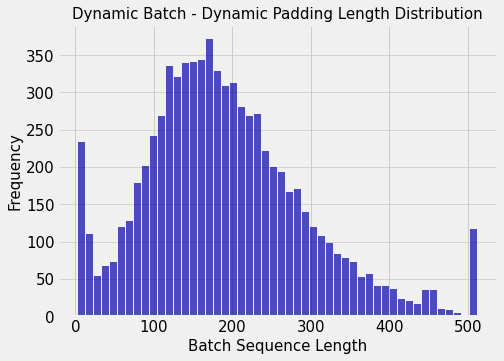

In [17]:
with plt.style.context('fivethirtyeight'):
    plt.figure(figsize=[7,5])
    n, bins, patches = plt.hist(x=batch_lengths_dynamic, bins=50, color='#0504aa',alpha=0.7, rwidth=0.85)
    plt.grid(axis='y', alpha=0.75)
    plt.xlabel('Batch Sequence Length',fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)
    plt.ylabel('Frequency',fontsize=15)
    plt.title('Dynamic Batch - Dynamic Padding Length Distribution',fontsize=15)
    plt.show()

We now see that the expected per batch sequence length has reduced from 300 to 200.


## Checkpointing

One cool feature of `infinibatch` is that you can checkpoint a particular state in which the composed iterators is at and restore it back to that state. This is very cool considering it works recursively on the composed iterators and even on infinite iterator. Let's recreate our iterators and check this out. 


In [18]:
#collapse-hide
sentence_it = datasets.chunked_dataset_iterator(
    chunk_refs = glob.glob('wikitext-103-chunks/train.*.txt.gz'),
    read_chunk_fn = read_chunk,
    buffer_size = 100000, 
    seed = 1337, 
    train=False, 
    shuffle=False
)
features_it = iterators.ParallelMapIterator(
    source_iterator=sentence_it,
    num_processes=4,
    num_items_per_process=1000,
    transform=tokenize_fn
)
batches_it = iterators.BucketedReadaheadBatchIterator(
    source_iterator=features_it,
    read_ahead=10000, # Determines the window for the bucket which
    # will be sorted and  converted to batches.
    key=lambda example: len(example['input_ids']), # Determines the length used
    # to sort and choose the longest remaining record.
    batch_size=lambda longest: tokens_per_batch // len(longest['input_ids']),
    # Determines the dynamic batch size
    seed=0 
)
collate_fn = partial(tokenizer.pad, return_tensors='pt')
tensors_it = iterators.MapIterator(
    batches_it,
    transform=collate_fn
)

In [19]:
initial_state = tensors_it.getstate() 
print("Initial State of composed iterators", initial_state)
# Draw 5 batches
batches = [next(tensors_it) for _ in range(5)]
print(f"Current State after sampling 5 batches: {tensors_it.getstate()}")

# Reset the Iterator
tensors_it.setstate(initial_state)
# Redraw 5 batches
redraw_batches = [next(tensors_it) for _ in range(5)]
print(f"State after resampling 5 batches: {tensors_it.getstate()}")


# Check equal
all_equal = True
for b1, b2 in zip(batches, redraw_batches):
    for k in b1:
        if torch.all(b1[k].eq(b2[k])):
            continue
        all_equal = False
        break
    if not all_equal:
        break
print(f"All items drawn after resetting are equal: {all_equal}")

Initial State of composed iterators {'source_state': None, 'random_state': None, 'num_served': 0}
Current State after sampling 5 batches: {'source_state': {'source_state': None, 'flattened_items_yielded': 0}, 'random_state': (3, (2147483648, 766982754, 497961170, 3952298588, 2331775348, 1811986599, 3100132149, 3188119873, 3937547222, 215718963, 3315684082, 2978012849, 2428261856, 1298227695, 1704729580, 54668373, 3285201915, 3285178464, 1552935063, 988471319, 3135387943, 1691402966, 2757551880, 416056905, 907387413, 1072924981, 33903495, 2168419592, 2429050353, 831159753, 430343641, 3315943586, 1761671042, 864453023, 334804929, 1627478028, 2596811275, 3468733638, 3994375553, 1457139722, 3139722021, 1334790738, 2656639915, 3535811098, 1464315470, 2397423927, 885719490, 1140895889, 3284299483, 2854516462, 2734973817, 147484763, 792049954, 114360641, 3345458839, 1159898878, 1410498733, 2242989638, 453922141, 1344019764, 413870456, 3089405849, 1494382840, 470157779, 4266372830, 2831181573,

Since the `state` of the iterator is just a dictionary, you can serialize it along with your model weights and restore them to continue training from exact point where you have checkpointed it.

# Making Infinibatch work with Pytorch Dataloaders

Infinibatch by its very nature can be used only with `IterableDataset`. The training iterator with shuffling is infinite, so you must limit the training batches to some `n` steps if you want to maintain the notion of "epochs" to start validation. Or you can eschew whole notion of epochs by validating every `nth` step.

> Note: The multi processing workers of `DataLoader` should be set to zero, with `num_workers=0`. Rather use `ParallelMapIterator` to parallelize your pre-processing.


> Note: While using `IterableDataset` and typical multi-gpu `DistributedDataParallel` (ddp) , you can pass `instance_rank` and `num_instances` as we will see in the final example below.

> Warning: When using finite iterators with `ddp` for validation set, if you split the data using `instance_rank` option, the validation can get stuck.

This can happen either when your dataset is not divisible by number of `ddp` processes or doing dynamic batching caused an uneven number of batches produced for each instance. So it's better to do the validation in one GPU setting `instance_rank=0`. This is a quick hack, if you find a better option please let me know in the comments.

In [20]:
from torch.utils.data import IterableDataset


class IterableCheckpointedDataset(IterableDataset):
    """
    Wraps a CheckpointableIterator into a PyTorch IterableDataset, which is 
    recognized by its type by PyTorch's DataLoader class.
    """

    def __init__(self, source: iterators.CheckpointableIterator, 
                 should_reset: bool):
        super().__init__()
        self._source = source
        self._source_state = source.getstate()
        self._should_reset = should_reset

    def __iter__(self):  # this is called in the forked clone
        worker_info = torch.utils.data.get_worker_info()
        assert (
            worker_info is None or worker_info.num_workers == 1
        )  # not supported since we can't get at the checkpoint for each worker

        if self._should_reset:
            # For training, since it's infinite iterator, if we train for 
            # `n` batches with total instances less than dataset size
            # it's better not to reset the iterator by itself will cycle back
            # with a new shuffle order when all the instances are iterated once.
            self._source.setstate(self._source_state)
        return self._source



def create_wiki_dataloader(chunks_glob: str,
                           tokenizer: PreTrainedTokenizerFast,
                           is_train: bool,
                           max_seq_len: int = 512,
                           tokens_per_batch: int = 2 ** 16, 
                           num_workers: int = 4,
                           buffer_size: int = 100000, 
                           seed: int = 1337) -> DataLoader:
    sentence_it = datasets.chunked_dataset_iterator(
        chunk_refs = glob.glob(chunks_glob),
        read_chunk_fn = read_chunk,
        buffer_size = buffer_size, 
        seed = seed, 
        train=is_train, 
        shuffle=is_train # Shuffle Only on Train
    )
    tokenize_fn = partial(tokenizer, max_length=max_seq_len, truncation=True)
    features_it = iterators.ParallelMapIterator(
        source_iterator=sentence_it,
        num_processes=num_workers,
        num_items_per_process=1000,
        transform=tokenize_fn
    )
    batches_it = iterators.BucketedReadaheadBatchIterator(
        source_iterator=features_it,
        read_ahead=10000, 
        key=lambda example: len(example['input_ids']),
        batch_size=lambda longest: tokens_per_batch // len(longest['input_ids']),
        seed=seed
    )
    collate_fn = partial(tokenizer.pad, return_tensors='pt')
    tensors_it = iterators.MapIterator(
        batches_it,
        transform=collate_fn
    )
    dataset = IterableCheckpointedDataset(
        source=tensors_it,
        should_reset=not is_train #Reset only for validation
    )
    return DataLoader(dataset, 
                      # Very important to set this to 0.
                      num_workers=0,
                      # Important as we have already batched. 
                      batch_size=1,
                      # Since batch has only one member which has all the 
                      #tensors already collated, we just return it.
                      collate_fn=lambda x: x[0] 
                      )

tokenizer = AutoTokenizer.from_pretrained("bert-base-cased", use_fast=True)
train_loader = create_wiki_dataloader('wikitext-103-chunks/train.*.txt.gz',
                                      tokenizer=tokenizer,
                                      is_train=True)

val_loader =  create_wiki_dataloader('wikitext-103-chunks/train.*.txt.gz',
                                      tokenizer=tokenizer,
                                      is_train=False)

#print(next(iter(train_loader)))
#print(next(iter(val_loader)))